# Analyzing COVID-19 Tweets using Distil BERT and Naive Bayes


**Columns:**
- Location  
- Tweet At  
- Original Tweet  
- Sentiment

**Models**  
I used a baseline Naive Bayes model and a Neural Network archiecture using DistilBERT as the embedding layer with a LSTM and Dense layers following. I used huggingface's transformers library and tensorflow for the deep learning model and scikit-learn for the naive bayes model. I also used GPU acceleration through a GTX 1060 (6GB) for training the neural network. 

<hr>

In [80]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Imports**

In [81]:
import os
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm # Progress Bar
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import transformers
from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import warnings
from transformers import logging as hf_logging
hf_logging.set_verbosity_error() # Hidding Huggingface Warnings
warnings.filterwarnings("ignore")

Enabling GPU

In [82]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [83]:
plt.style.use('ggplot')

**DistilBERT Model**

In [84]:
MODEL_NAME = 'distilbert-base-cased'

In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
test_df = pd.read_csv('/content/drive/MyDrive/Corona_NLP_test.csv', encoding = "UTF-8", encoding_errors='ignore')
train_df = pd.read_csv('/content/drive/MyDrive/Corona_NLP_train.csv', encoding = "UTF-8", encoding_errors='ignore')

### Loading Data

Dropping  duplicates 

In [87]:
train_df.drop_duplicates(inplace= True)
test_df.drop_duplicates(inplace=True)

In [88]:
train_df.isna().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [89]:
test_df.isna().sum()

UserName           0
ScreenName         0
Location         834
TweetAt            0
OriginalTweet      0
Sentiment          0
dtype: int64

In [90]:
print(f"There are {train_df.shape[0]} entries in the training dataframe")
train_df.head()

There are 41157 entries in the training dataframe


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [91]:
print(f"There are {test_df.shape[0]} entries in the test dataframe")
test_df.head()

There are 3798 entries in the test dataframe


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


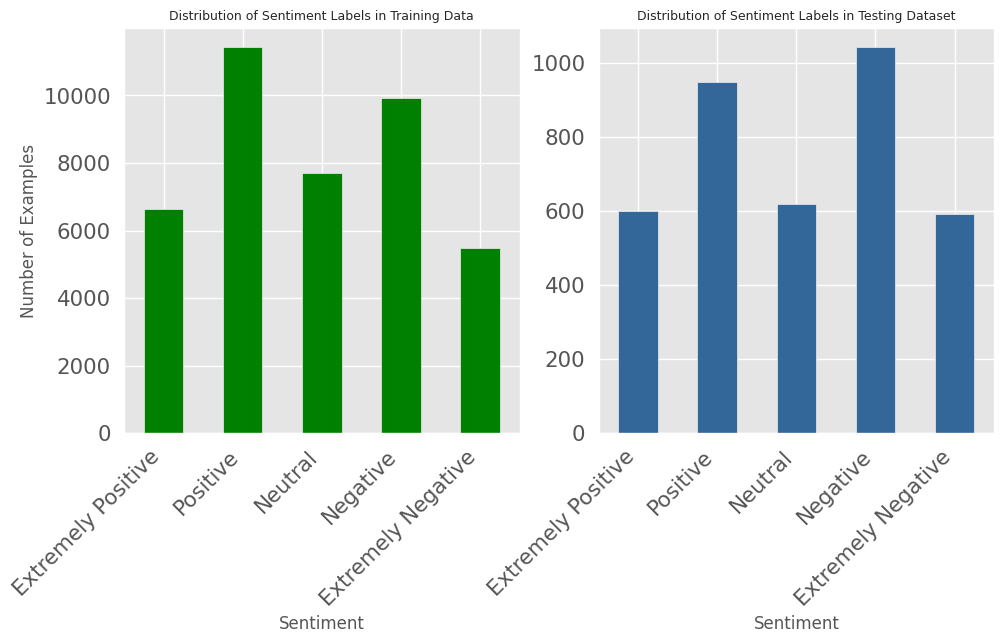

In [92]:
reorder = ['Extremely Positive', 'Positive', 'Neutral', 'Negative', 'Extremely Negative']

fig, axes = plt.subplots(1,2 , figsize=(10,5))

train_df.value_counts('Sentiment').reindex(index=reorder).plot(kind='bar', ax=axes[0],color='green')
plt.sca(axes[0])
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Distribution of Sentiment Labels in Training Data',fontsize=9)
plt.ylabel('Number of Examples')

test_df.value_counts('Sentiment').reindex(index=reorder).plot(kind='bar', ax=axes[1],color=(0.2, 0.4, 0.6))
plt.sca(axes[1])
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Distribution of Sentiment Labels in Testing Dataset',fontsize=9);

Seems like the training and testsing datasets are not balanced across all categories.

In [93]:
max_words = []
for row in train_df['OriginalTweet']:
    max_words.append(len(row.split()))
print(f"The max word count is {np.asarray(max_words).max()}")

The max word count is 64


#WordCloud

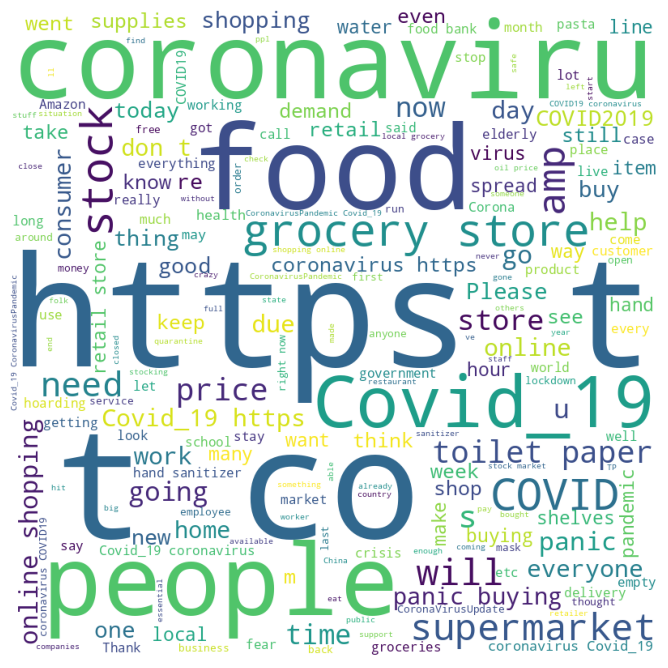

In [94]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# Load the dataset from CSV file
df = pd.read_csv('/content/drive/MyDrive/Corona_NLP_test.csv', encoding = "UTF-8", encoding_errors='ignore')
df['CleanedText'] = df['OriginalTweet']
# Concatenate all the text data into a single string
text = ' '.join(df['CleanedText'].astype(str).tolist())

# Generate the wordcloud
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(text)

# Plot the wordcloud
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

**Getting rid of the URL's in the tweets**

In [95]:
test_str = test_df['OriginalTweet'][0]
print(test_str)

def remove_https(row):
    return re.sub(r'http\S+', '', row)

remove_https(test_str)

TRENDING: New Yorkers encounter empty supermarket shelves (pictured, Wegmans in Brooklyn), sold-out online grocers (FoodKick, MaxDelivery) as #coronavirus-fearing shoppers stock up https://t.co/Gr76pcrLWh https://t.co/ivMKMsqdT1


'TRENDING: New Yorkers encounter empty supermarket shelves (pictured, Wegmans in Brooklyn), sold-out online grocers (FoodKick, MaxDelivery) as #coronavirus-fearing shoppers stock up  '

#Word Cloud without https

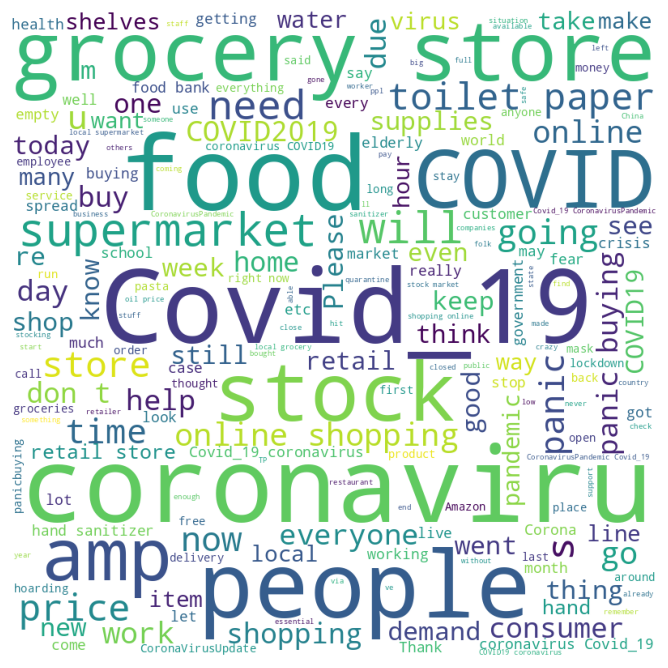

In [96]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# Load the dataset from CSV file
#df = pd.read_csv('/content/drive/MyDrive/Corona_NLP_test.csv', encoding = "UTF-8", encoding_errors='ignore')
df['CleanedText'] = test_df['OriginalTweet'].apply(remove_https)
# Concatenate all the text data into a single string
text = ' '.join(df['CleanedText'].astype(str).tolist())

# Generate the wordcloud
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(text)

# Plot the wordcloud
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

*Apply to whole datasets*

In [97]:
train_df['OriginalTweet_no_URL'] = train_df['OriginalTweet'].apply(remove_https)
test_df['OriginalTweet_no_URL'] = test_df['OriginalTweet'].apply(remove_https)

**Label Encode the datasets**

In [98]:
le = LabelEncoder()
train_df['Sentiment_label'] = le.fit_transform(train_df['Sentiment'])
test_df['Sentiment_label'] = le.transform(test_df['Sentiment'])

In [99]:
label_dict = (test_df[['Sentiment','Sentiment_label']].drop_duplicates()
              .sort_values(by='Sentiment_label')
              .reset_index(drop=True)['Sentiment']
              .to_dict())

for index, key in label_dict.items():
    print(index, key)

0 Extremely Negative
1 Extremely Positive
2 Negative
3 Neutral
4 Positive


**Splitting the data**

Taking 10% of the training data as validation data

In [100]:
# Get the number training samples
num_train_samples = int(train_df.shape[0] * 0.9)

x_train = train_df['OriginalTweet_no_URL'][:num_train_samples]
y_train = train_df['Sentiment_label'][:num_train_samples]
x_val = train_df['OriginalTweet_no_URL'][num_train_samples:]
y_val = train_df['Sentiment_label'][num_train_samples:]

### Sanity Check
assert(len(x_train) + len(x_val) == train_df.shape[0])

print(f"{len(x_train)} training examples\n{len(x_val)} validation examples")


37041 training examples
4116 validation examples


In [101]:
x_test = test_df['OriginalTweet_no_URL']
y_test = test_df['Sentiment_label']
print(f"{len(x_test)} testing examples")

3798 testing examples


## Naive Bayes (Baseline Model)

Pre-processing by:  
- remove punctuations (except #)
- lowercase all words
- removing stopwords
- stemming words
- removing numbers

In [102]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [103]:
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
porter = PorterStemmer()

# Remove all puncutation
def clean_responses(text):
    ### Remove numbers
    text = re.sub(r'\d+', '', text)
    
    ### Lowercase
    text = text.lower()
    ### Remove all puncutation
    string.punctuation = string.punctuation.replace('#','')
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    
    ### Removing stop words
    filtered_words = []
    for word in text.split():
        if word not in stop_words:
            filtered_words.append(word)
            
    ### Stemming words
    stemmed = [porter.stem(word) for word in filtered_words]
                
    return ' '.join(stemmed)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [104]:
X_train_NB = train_df['OriginalTweet_no_URL'].apply(clean_responses)
y_train_NB = train_df['Sentiment_label']
X_test_NB = test_df['OriginalTweet_no_URL'].apply(clean_responses)
y_test_NB = test_df['Sentiment_label']

#Hyperparameter Tuning

In [105]:
# model = pipeline(TfidfVectorizer(), MultinomialNB())
# model.fit(X_train_NB, y_train_NB)

# ### Make predictions
# y_hat = model.predict(X_test_NB)



from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB())
])

parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'clf__alpha': [0.01, 0.1, 1, 10, 100]
}

model = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1)
model.fit(X_train_NB, y_train_NB)

best_score = model.best_score_
best_params = model.best_params_

y_hat = model.predict(X_test_NB)

Accuracy: 0.44075829383886256


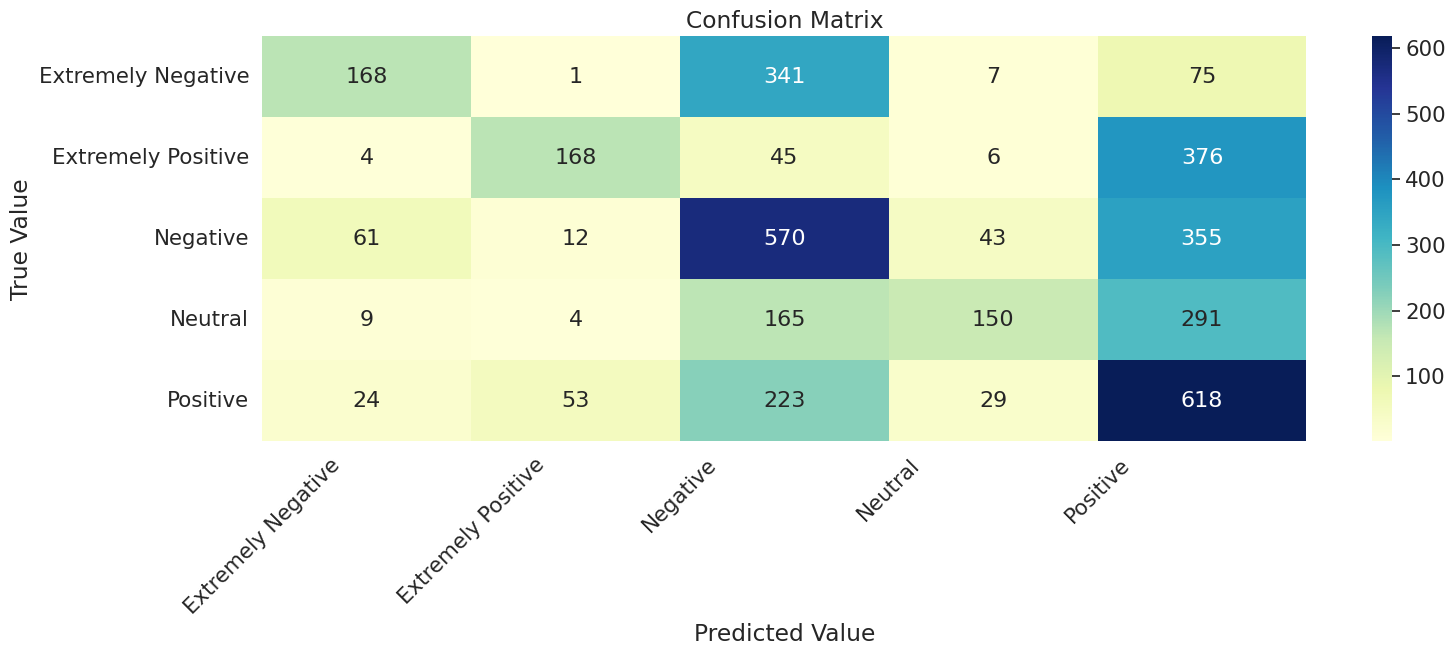

In [106]:
print("Accuracy:", accuracy_score(y_test_NB, y_hat))
labels_5 = ['Extremely Negative','Extremely Positive','Negative','Neutral','Positive'] 

def print_cf1(y_test, y_hat):
    cm = confusion_matrix(y_test, y_hat)
    sns.set(font_scale = 1.4, color_codes=True, palette="deep")
    sns.heatmap(pd.DataFrame(cm, index=labels_5,columns=[0,1,2,3,4]), 
                annot = True,
                annot_kws = {"size":16},
                fmt="d",
                cmap="YlGnBu")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Value")
    plt.xticks([0,1,2,3,4], labels_5, rotation=45)
    plt.ylabel("True Value")
    plt.show()
    
print_cf1(y_test_NB, y_hat)

In [107]:
print(classification_report(y_test_NB, y_hat, target_names=labels_5))

                    precision    recall  f1-score   support

Extremely Negative       0.63      0.28      0.39       592
Extremely Positive       0.71      0.28      0.40       599
          Negative       0.42      0.55      0.48      1041
           Neutral       0.64      0.24      0.35       619
          Positive       0.36      0.65      0.46       947

          accuracy                           0.44      3798
         macro avg       0.55      0.40      0.42      3798
      weighted avg       0.52      0.44      0.43      3798



In [108]:
date = train_df['TweetAt'].value_counts()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 [Text(0, 0, '20-03-2020'),
  Text(1, 0, '19-03-2020'),
  Text(2, 0, '25-03-2020'),
  Text(3, 0, '18-03-2020'),
  Text(4, 0, '21-03-2020'),
  Text(5, 0, '22-03-2020'),
  Text(6, 0, '23-03-2020'),
  Text(7, 0, '17-03-2020'),
  Text(8, 0, '08-04-2020'),
  Text(9, 0, '07-04-2020'),
  Text(10, 0, '06-04-2020'),
  Text(11, 0, '24-03-2020'),
  Text(12, 0, '09-04-2020'),
  Text(13, 0, '13-04-2020'),
  Text(14, 0, '26-03-2020'),
  Text(15, 0, '05-04-2020'),
  Text(16, 0, '10-04-2020'),
  Text(17, 0, '02-04-2020'),
  Text(18, 0, '11-04-2020'),
  Text(19, 0, '03-04-2020'),
  Text(20, 0, '12-04-2020'),
  Text(21, 0, '04-04-2020'),
  Text(22, 0, '16-03-2020'),
  Text(23, 0, '01-04-2020'),
  Text(24, 0, '27-03-2020'),
  Text(25, 0, '31-03-2020'),
  Text(26, 0, '14-04-2020'),
  Text(27, 0, '29-03-2020'),
  Text(28, 0, '30-03-2020'),
  Text(29, 0, '28-03-2020')])

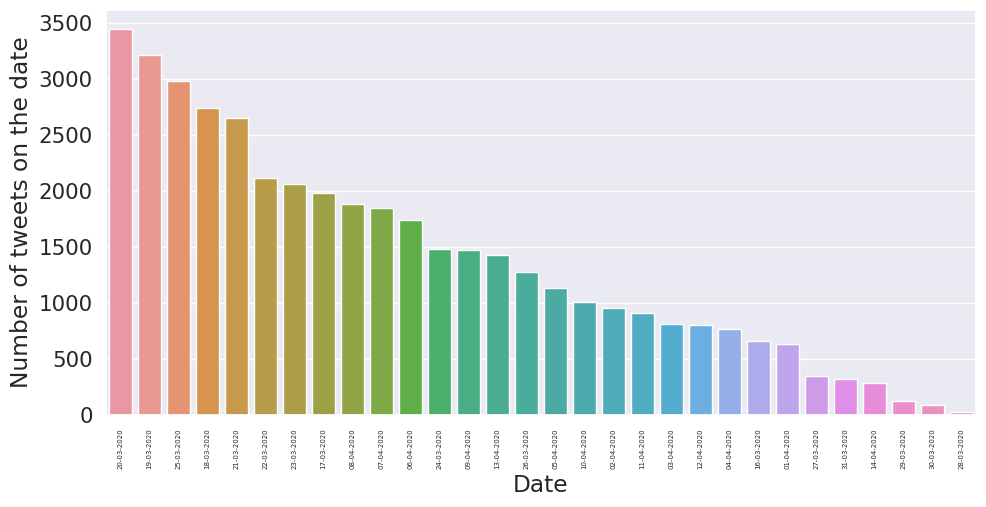

In [109]:
plt.figure(figsize=(10,5))
plt.xlabel("Date")
plt.xlim('02/03/2020','28/03/2020')
plt.ylabel("Number of tweets on the date")
sns.barplot(x=date.index,y=date.values)
plt.xticks(fontsize=5,rotation='vertical')

#Emotion Detection

In [110]:
filepath = r"/content/drive/MyDrive/NRC Emotion Lexicon (1).txt"
emolex_df = pd.read_csv(filepath,  names=["word", "emotion", "association"], skiprows=45, sep='\t')
emolex_df.head(12)


,word,emotion,association
0,abandonment,joy,0.0
1,abandonment,negative,1.0
2,abandonment,positive,0.0
3,abandonment,sadness,1.0
4,abandonment,surprise,1.0
5,abandonment,trust,0.0
6,abate,anger,0.0
7,abate,anticipation,0.0
8,abate,disgust,0.0
9,abate,fear,0.0


In [111]:
emotions={'positive':0, 'negative':0, 'surprise':0,'sadness':0,
          'anger':0,'joy':0,'negative':0,'trust':0,'fear':0,'anticipation':0,'disgust':0}

In [112]:
word_emotion=dict()
for i in range(0,86343):
    emotion=emolex_df['emotion'][i]
    word=emolex_df['word'][i]
    association=emolex_df['association'][i]
    
    if word not in word_emotion:
        word_emotion[word]=dict()
    word_emotion[word][emotion]=association 

In [113]:
for i in range(0,13525):
    text=train_df['OriginalTweet'][i]
    for j in text.split():
        if j in word_emotion:
            for k in word_emotion[j]:
                emotions[k]+=word_emotion[j][k]

In [114]:
emotions

{'positive': 9897.0,
 'negative': 6145.0,
 'surprise': 1689.0,
 'sadness': 2826.0,
 'anger': 2780.0,
 'joy': 4371.0,
 'trust': 6323.0,
 'fear': 3421.0,
 'anticipation': 3334.0,
 'disgust': 1388.0}

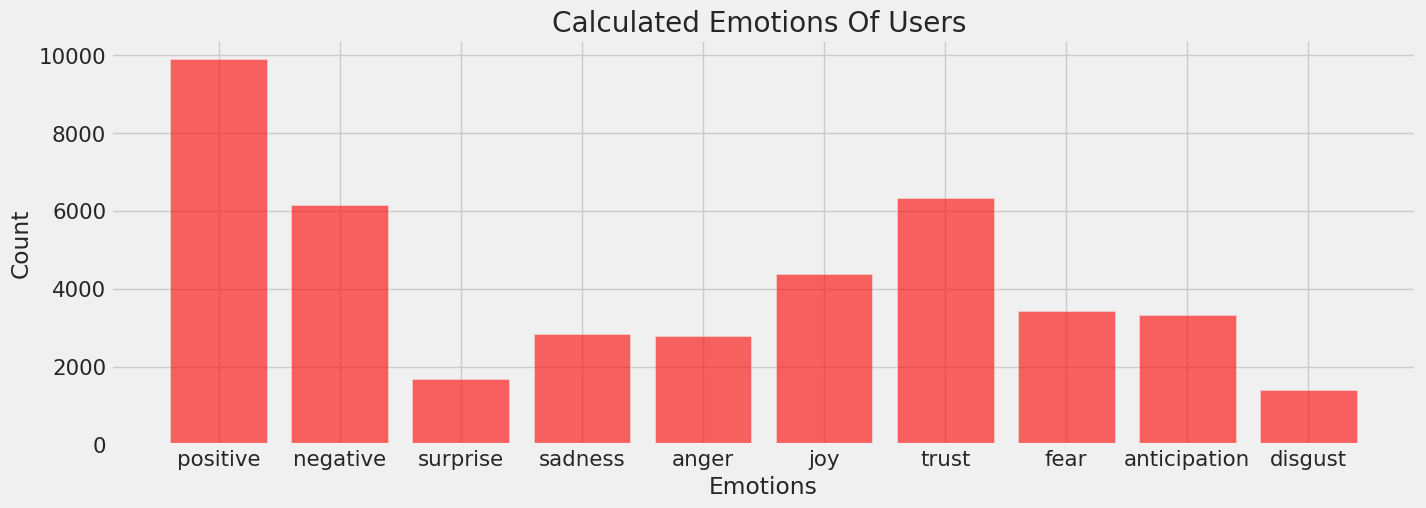

In [115]:
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = [15,5]
plt.bar(list(emotions.keys()),list(emotions.values()),color='red',alpha = 0.6)
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.title('Calculated Emotions Of Users ')
plt.show()

#Creating a new column for emotions

In [116]:
# create an empty list to store the labels for each tweet
labels = []

# iterate over each tweet in the "OriginalTweet" column
for tweet in train_df["OriginalTweet"].apply(clean_responses):
    # initialize a dictionary to store the total sentiment scores for each emotion
    emotions = {"anger": 0, "anticipation": 0, "disgust": 0, "fear": 0, "joy": 0, "sadness": 0, "surprise": 0, "trust": 0}
    # iterate over each word in the tweet
    for word in tweet.split():
        # check if the word is present in the word_emotion dictionary
        if word in word_emotion:
            # iterate over each emotion associated with the word and update the running total for each emotion
            for emotion, score in word_emotion[word].items():
                # add a check to see if the emotion is present in the word_emotion dictionary before updating the score
                if emotion in emotions:
                    emotions[emotion] += score
    # determine the dominant emotion for the tweet by finding the emotion with the highest score
    dominant_emotion = max(emotions, key=emotions.get)
    # add the dominant emotion to the labels list
    labels.append(dominant_emotion)

# add the labels list as a new column in the dataset
train_df["labels"] = labels


In [117]:
from tensorflow.keras.preprocessing.text import Tokenizer

#Tokenizing the Tweets

In [118]:
emotion_tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')

emotion_tokenizer.fit_on_texts(train_df.OriginalTweet.apply(remove_https).apply(clean_responses).tolist())

print(emotion_tokenizer.texts_to_sequences([train_df.OriginalTweet[10]]))

[[1, 179, 582, 1, 1, 1, 6450, 1, 1, 9331, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4925, 1, 1, 1, 1, 1, 1, 9244, 1, 1, 6, 8016, 67, 1, 1, 1, 7760, 820, 1]]


#Padding and Truncating Sequences

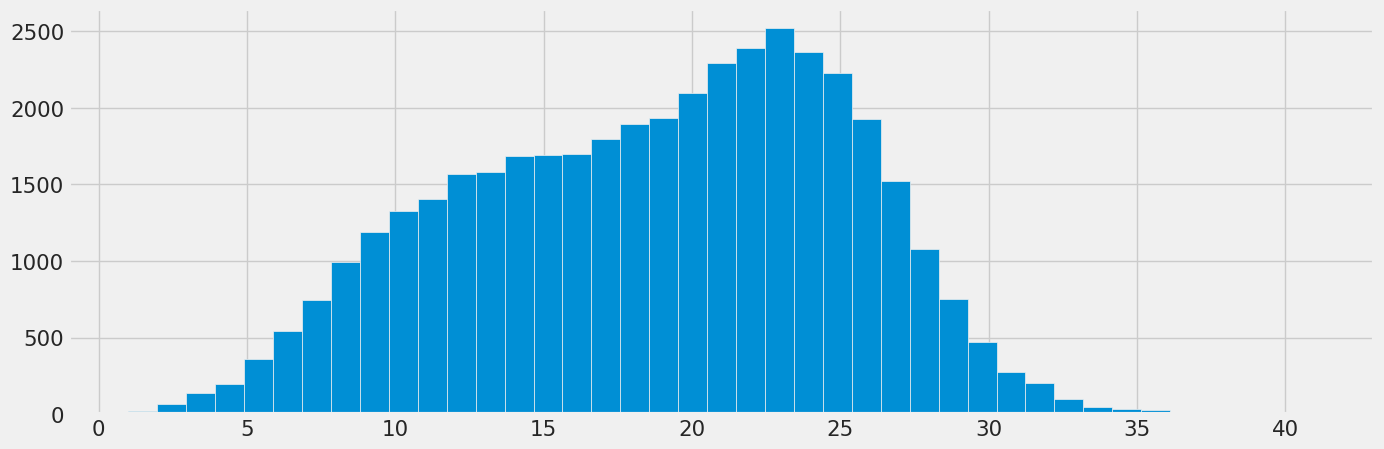

In [120]:
lengths = [len(t.split(' ')) for t in train_df.OriginalTweet.apply(clean_responses).tolist() ]

plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=50, padding='post')
    return padded_sequences

In [ ]:
# x_train = train_df['OriginalTweet_no_URL'][:num_train_samples]
# y_train = train_df['Sentiment_label'][:num_train_samples]
# x_val = train_df['OriginalTweet_no_URL'][num_train_samples:]
# y_val = train_df['Sentiment_label'][num_train_samples:]
z_train = train_df['labels'][:num_train_samples]
z_val = train_df['labels'][num_train_samples:]

# X_train_NB = train_df['OriginalTweet_no_URL'].apply(clean_responses)
# y_train_NB = train_df['Sentiment_label']
# X_test_NB = test_df['OriginalTweet_no_URL'].apply(clean_responses)
# y_test_NB = test_df['Sentiment_label']

In [ ]:
tweets = x_train.apply(clean_responses).tolist()
labeltweets = z_train.tolist()

In [ ]:
len(z_train)

In [ ]:
tweets[100]

In [ ]:
labeltweets[100]

In [ ]:
padded_train_sequences = get_sequences(emotion_tokenizer, tweets)
padded_train_sequences[10]

In [ ]:
#Labels

In [ ]:
classes = set(labeltweets)
print(classes)
classes_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_classes = dict((v, k) for k, v in classes_to_index.items())
classes_to_index
names_to_ids = lambda labeltweets: np.array([classes_to_index.get(x) for x in labeltweets])

In [ ]:
train_labels = names_to_ids(labeltweets)


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=50),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

In [ ]:
abtweets = x_val.apply(clean_responses).tolist()
ablabeltweets = z_val.tolist()

In [ ]:
len(z_val)+len(z_train)

In [ ]:
z_val

In [ ]:
val_tweets, val_labels = abtweets , ablabeltweets
val_sequences = get_sequences(emotion_tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [ ]:
val_tweets[20], val_labels[20]

In [ ]:
h = model.fit(
    padded_train_sequences, train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=15,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

In [ ]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

show_history(h)

In [ ]:
# # Load the dataset into a pandas dataframe
# #klldf = pd.read_csv('/content/drive/MyDrive/Corona_NLP_test.csv')

# # Specify the column you want to check for majority class
# column_name = 'Sentiment'

# # Calculate the value counts of each class in the column
# class_counts = df[column_name].value_counts()

# # Find the class with the highest count (the majority class)
# majority_class = class_counts.index[0]

# # Print the majority class
# print(f"Majority class in {column_name} column: {majority_class}")

# minority_class = class_counts.index[-1]

# # Print the minority class
# print(f"Minority class in {column_name} column: {minority_class}")

**Results**

## DistilBERT

**Tokenize the Inputs** 

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME) # Loading the tokenizer

*Finding the max token sequence in the training set*

In [ ]:
max_val = 0
for sent in (x_train.tolist() + x_train.tolist() + x_val.tolist()):
    try:
        sent_tok_len = len(tokenizer.tokenize(sent))
        max_val = sent_tok_len if (sent_tok_len > max_val) else max_val
    except:
        pass
    
print(f"The maximum amount of tokens in the dataset is {max_val}")

I will set the max length and input for the deep learning model to 234  
*(Max token length + 2 for special characters [CLS] and [SEP])*

In [ ]:
MAX_LENGTH = 234

tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME,  
                                                add_special_tokens=True,
                                                max_length=MAX_LENGTH, 
                                                pad_to_max_length=True)

def tokenize(sentences, tokenizer):
    input_ids, input_masks, input_segments = [], [], []
    for sentence in tqdm(sentences):
        inputs = tokenizer.encode_plus(sentence, 
                                       add_special_tokens=True, 
                                       max_length=MAX_LENGTH, 
                                       pad_to_max_length=True, 
                                       return_attention_mask=True, 
                                       return_token_type_ids=True, 
                                       truncation=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])        
        
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32')

In [ ]:
X_train = tokenize(x_train, tokenizer)
X_test = tokenize(x_test, tokenizer)
X_val = tokenize(x_val, tokenizer)

**Looking at entry**

In [ ]:
index_num = 5

print(train_df.loc[index_num]['Sentiment'], '\n')

print(x_train[index_num], '\n')

temp_tokens = tokenizer.tokenize(x_train[index_num])
temp_ids = tokenizer.encode(x_train[index_num])

print('ID\'s', 'Input Tokens', sep='\t')
for i in range(len(temp_ids)):
    if i == 0:
        print(temp_ids[i], '[CLS]', sep='\t')
        continue
    if i == len(temp_ids)-1:
        print(temp_ids[i], '[SEP]', sep='\t')
        break
    print(temp_ids[i], temp_tokens[i-1], sep='\t')

### Creating the model

distilbert-base-uncased

In [ ]:


# from transformers import TFDistilBertModel, DistilBertConfig

# # Change the pre-trained model to DistilBERT
# MODEL_NAME = 'distilbert-base-uncased'
# config = DistilBertConfig.from_pretrained(MODEL_NAME, output_hidden_states=True, output_attentions=True)
# DistilBERT = TFDistilBertModel.from_pretrained(MODEL_NAME, config=config)

# input_ids_in = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='input_token', dtype='int32')
# input_masks_in = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='masked_token', dtype='int32') 

# embedding_layer = DistilBERT(input_ids = input_ids_in, attention_mask = input_masks_in)[0]
# X = tf.keras.layers.GlobalMaxPool1D()(embedding_layer)
# X = tf.keras.layers.Dense(256, activation='relu')(X)
# X = tf.keras.layers.Dropout(0.2)(X)
# X = tf.keras.layers.Dense(5, activation='softmax')(X)

# model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs=X)

# # Fine-tune more layers of the pre-trained model
# for layer in model.layers[:-3]:
#     layer.trainable = False

# # Change the optimizer and learning rate
# optimizer = tf.keras.optimizers.Adam(lr=1e-5)

# model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

In [ ]:
config = DistilBertConfig.from_pretrained(MODEL_NAME, output_hidden_states=True, output_attentions=True)
DistilBERT = TFDistilBertModel.from_pretrained(MODEL_NAME, config=config)

input_ids_in = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='masked_token', dtype='int32') 

embedding_layer = DistilBERT(input_ids = input_ids_in, attention_mask = input_masks_in)[0]
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(embedding_layer)
X = tf.keras.layers.GlobalMaxPool1D()(X)
X = tf.keras.layers.Dense(64, activation='relu')(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(5, activation='softmax')(X)

model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = X)

for layer in model.layers[:3]:
    layer.trainable = False

model.summary()

*Creating a output directory to store the models weights*

In [ ]:
### Create an output directory
output_dir = './model1_outputs'
if not os.path.exists(output_dir): ### If the file directory doesn't already exists,
    os.makedirs(output_dir) ### Make it please

*Callbacks*

In [ ]:
model_checkpoint = ModelCheckpoint(filepath=output_dir+'/weights.{epoch:02d}.hdf5',
                                  save_weights_only=True)

early_stopping = EarlyStopping(patience=3, # Stop after 3 epochs of no improvement
                               monitor='val_loss', # Look at validation_loss
                               min_delta=0, # After 0 change
                               mode='min', # Stop when quantity has stopped decreasing
                               restore_best_weights=False, # Don't Restore the best weights
                               verbose=1) 

reduce_lr = ReduceLROnPlateau(monitor='val_loss', # Look at validation loss
                              min_lr=0.000001, # Lower bound of learning rate
                              patience=1, # Reduce after 1 with little change
                              mode='min', # Stop when quantity has stopped decreasing
                              factor=0.1, # Reduce by a factor of 1/10
                              min_delta=0.01, # Minimumn change needed
                              verbose=1)

In [ ]:
import tensorflow as tf

# Create a session with GPU device
with tf.device('/gpu:0'):
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(X_train, 
                    y_train, 
                    epochs = 10,
                    batch_size=16, 
                    validation_data=(X_val, y_val), 
                    callbacks=[model_checkpoint, early_stopping, reduce_lr])

Plotting the training accuracy and loss

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    print("Lowest Validation Loss: epoch {}".format(np.argmin(val_loss)+1))
    print("Highest Validation Accuracy: epoch {}".format(np.argmax(val_acc)+1))

plot_history(history)

Loading the model with the best validation accuracy

In [ ]:
def get_min_val_loss_epoch(history):
    return "0"+str(np.argmin(history.history['val_loss'])+1)

def get_max_val_acc_epoch(history):
    return "0"+str(np.argmax(history.history['val_accuracy'])+1)

In [ ]:
epoch_num = get_max_val_acc_epoch(history)
model.load_weights(output_dir+"/weights."+epoch_num+".hdf5") # Load in model weights

**Making inference on the test data**

In [ ]:
y_test_probs = model.predict(X_test)

# Turn probabilities into an interger prediction
y_hat = []
for prob in y_test_probs:
    y_hat.append(np.argmax(prob))

**Results**

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_hat))
print_cf1(y_test, y_hat)

In [ ]:
print(classification_report(y_test, y_hat, target_names=labels_5))

## Combining Labels and Re-Running

In [121]:

label_mapping = {'Extremely Positive': 'Positive', 'Extremely Negative': 'Negative'}
train_df['Simple_Sentiment'] = train_df['Sentiment'].replace(label_mapping)
test_df['Simple_Sentiment'] = test_df['Sentiment'].replace(label_mapping)
label_dict = dict(zip(range(len(le.classes_)), sorted(le.classes_)))
label_mapping = {'Extremely Positive': 'Positive', 'Extremely Negative': 'Negative'}
train_df['Simple_Sentiment'] = train_df['Sentiment'].replace(label_mapping)
test_df['Simple_Sentiment'] = test_df['Sentiment'].replace(label_mapping)

le = LabelEncoder()
train_df['Simple_Sentiment_label'] = le.fit_transform(train_df['Simple_Sentiment'])
test_df['Simple_Sentiment_label'] = le.transform(test_df['Simple_Sentiment'])

label_dict = dict(zip(range(len(le.classes_)), sorted(le.classes_)))

for index, key in label_dict.items():
    print(index, key)


0 Negative
1 Neutral
2 Positive


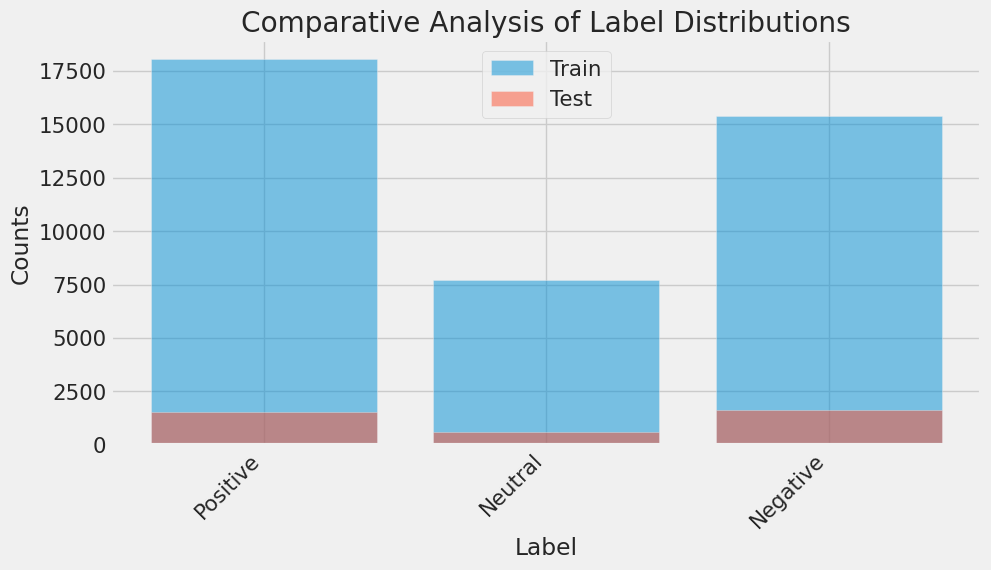

In [122]:

import matplotlib.pyplot as plt

reorder_labels = [2, 1, 0]
reorder = ['Positive', 'Neutral', 'Negative']

train_counts = train_df['Simple_Sentiment_label'].value_counts().reindex(reorder_labels)
test_counts = test_df['Simple_Sentiment_label'].value_counts().reindex(reorder_labels)

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(reorder, train_counts, alpha=0.5, label='Train')
ax.bar(reorder, test_counts, alpha=0.5, label='Test')
ax.set_xticklabels(reorder, rotation=45, ha='right')
ax.set_title('Comparative Analysis of Label Distributions')
ax.set_xlabel('Label')
ax.set_ylabel('Counts')
ax.legend()

plt.show()



Splitting datasets

In [123]:
### Only need to modify the labels
y_train = train_df['Simple_Sentiment_label'][:num_train_samples]
y_val = train_df['Simple_Sentiment_label'][num_train_samples:]
y_test = test_df['Simple_Sentiment_label']

print(f"{len(y_train)} training examples\n{len(y_val)} validation examples")
print(f"{len(y_test)} testing examples")

37041 training examples
4116 validation examples
3798 testing examples


### Naive Bayes (Baseline)

In [124]:
y_train_NB = train_df['Simple_Sentiment_label']
y_test_NB = test_df['Simple_Sentiment_label']

In [125]:
model = make_pipeline(TfidfVectorizer(), MultinomialNB())
model.fit(X_train_NB, y_train_NB)

### Make predictions
y_hat = model.predict(X_test_NB)


from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB())
])

parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'clf__alpha': [0.01, 0.1, 1, 10, 100]
}

model = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1)
model.fit(X_train_NB, y_train_NB)

best_score = model.best_score_
best_params = model.best_params_

y_hat = model.predict(X_test_NB)

**Results**

Accuracy: 0.6695629278567667


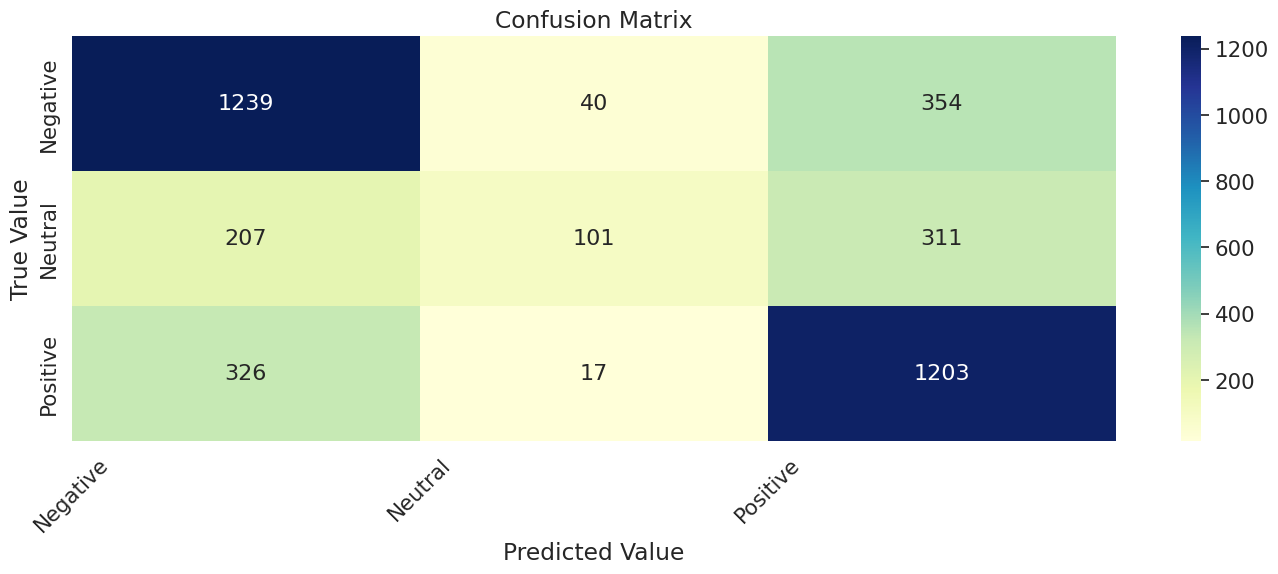

In [127]:
print("Accuracy:", accuracy_score(y_test_NB, y_hat))
labels_3 = ['Negative','Neutral','Positive'] 

def print_cf2(y_test, y_hat):
    cm = confusion_matrix(y_test, y_hat)
    sns.set(font_scale = 1.4, color_codes=True, palette="deep")
    sns.heatmap(pd.DataFrame(cm, index=labels_3,columns=[0,1,2]), 
                annot = True,
                annot_kws = {"size":16},
                fmt="d",
                cmap="YlGnBu")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Value")
    plt.xticks([0,1,2], labels_3, rotation=45)
    plt.ylabel("True Value")
    plt.show()
    
print_cf2(y_test_NB, y_hat)

In [ ]:
print(classification_report(y_test_NB, y_hat, target_names=labels_3))

              precision    recall  f1-score   support

    Negative       0.70      0.76      0.73      1633
     Neutral       0.64      0.16      0.26       619
    Positive       0.64      0.78      0.70      1546

    accuracy                           0.67      3798
   macro avg       0.66      0.57      0.56      3798
weighted avg       0.67      0.67      0.64      3798



Our baseline to beat is **63% accuracy** in our predictions

## DistilBERT

### Creating the model

In [ ]:
config = DistilBertConfig.from_pretrained(MODEL_NAME, output_hidden_states=True, output_attentions=True, return_dict=True)
DistilBERT = TFDistilBertModel.from_pretrained(MODEL_NAME, config=config)

input_ids_in = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='input_token', dtype='int32')
attention_mask_in = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='masked_token', dtype='int32') 

embedding_layer = DistilBERT(input_ids = input_ids_in, attention_mask = attention_mask_in)[0]
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(embedding_layer)
X = tf.keras.layers.GlobalMaxPool1D()(X)
X = tf.keras.layers.Dense(64, activation='relu')(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(3, activation='softmax')(X)

model = tf.keras.Model(inputs=[input_ids_in, attention_mask_in], outputs = X)

for layer in model.layers[:3]:
    layer.trainable = False

model.summary()

*Creating a new output director to store the models weights*

In [ ]:
### Create an output directory
output_dir = './model2_outputs'
if not os.path.exists(output_dir): ### If the file directory doesn't already exists,
    os.makedirs(output_dir) ### Make it please

**Compile and train**

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, 
                    y_train, 
                    epochs = 10,
                    batch_size=16, 
                    validation_data=(X_val, y_val), 
                    callbacks=[model_checkpoint, early_stopping, reduce_lr])

Plotting the training accuracy and loss

In [ ]:
plot_history(history)

Loading the model weights with the best validation accuracy

In [ ]:
epoch_num = get_max_val_acc_epoch(history)
model.load_weights(output_dir+"/weights."+epoch_num+".hdf5") # Load in model weights

**Making Inference**

In [ ]:
y_test_probs = model.predict(X_test)

# Turn probabilities into an interger prediction
y_hat = []
for prob in y_test_probs:
    y_hat.append(np.argmax(prob))

**Results**

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_hat))
print_cf2(y_test, y_hat)

In [ ]:
print(classification_report(y_test, y_hat, target_names=labels_3))

### Looking at which tweets we guessed incorrectly 

Observations that were predicted **Negative** (y_hat = 0) but actually **Positive** (y_test = 2)

*Printing the first 5 examples*

In [ ]:
[print(example, '\n') for example in x_test[(y_test == 2) & (np.asarray(y_hat) == 0)][:5]];

Observations that were predicted **Positive** (y_hat = 2) but actually **Negative** (y_test = 0)

*Printing the first 5 examples*

In [ ]:
[print(example, '\n') for example in x_test[(y_test == 0) & (np.asarray(y_hat) == 2)][:5]];